# Dataset Exploration and Preprocessing Notebook

This notebook inspects the SDNET2018 and CCIC datasets for:
- Label balance (crack vs. no-crack images)
- Lighting conditions (brightness analysis)
- Image resolutions (to plan standardization to 224x224)

It also demonstrates resizing to 224x224 as a preprocessing step.

In [2]:
import os
import glob
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from tqdm import tqdm

# Paths to datasets
SDNET_PATH = '../data/raw/sdnet2018'
CCIC_PATH = '../data/raw/ccic'

# Helper function to get image paths and labels
def get_image_paths_and_labels(dataset_path, label_map=None):
    paths = []
    labels = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                paths.append(os.path.join(root, file))
                if label_map:
                    label = label_map.get(os.path.basename(root), 'unknown')
                else:
                    # For SDNET2018, infer from subfolder (e.g., 'crack' or 'no-crack')
                    label = 'crack' if 'crack' in root.lower() else 'no-crack'
                labels.append(label)
    return paths, labels

# Load SDNET2018 (assuming subfolders like bridge/crack, sidewalk/no-crack, etc.)
sdnet_paths, sdnet_labels = get_image_paths_and_labels(SDNET_PATH)

# Load CCIC (Positive = crack, Negative = no-crack)
ccic_label_map = {'Positive': 'crack', 'Negative': 'no-crack'}
ccic_paths, ccic_labels = get_image_paths_and_labels(CCIC_PATH, ccic_label_map)

# Combine datasets
all_paths = sdnet_paths + ccic_paths
all_labels = sdnet_labels + ccic_labels

print(f"Total images: {len(all_paths)}")
print(f"SDNET2018: {len(sdnet_paths)} images")
print(f"CCIC: {len(ccic_paths)} images")

Total images: 80000
SDNET2018: 40000 images
CCIC: 40000 images


## Inspect Label Balance

no-crack    60000
crack       20000
Name: count, dtype: int64


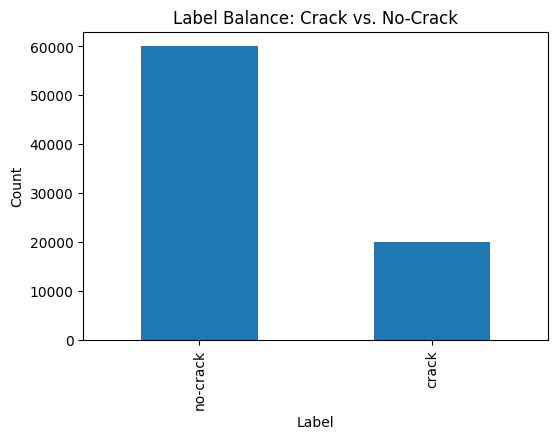

In [3]:
# Count labels
label_counts = pd.Series(all_labels).value_counts()
print(label_counts)

# Plot balance
plt.figure(figsize=(6, 4))
label_counts.plot(kind='bar')
plt.title('Label Balance: Crack vs. No-Crack')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

## Inspect Lighting Conditions

Analyze average brightness (mean pixel intensity) across images.

CCIC Brightness: 100%|██████████| 100/100 [00:00<00:00, 950.58it/s]


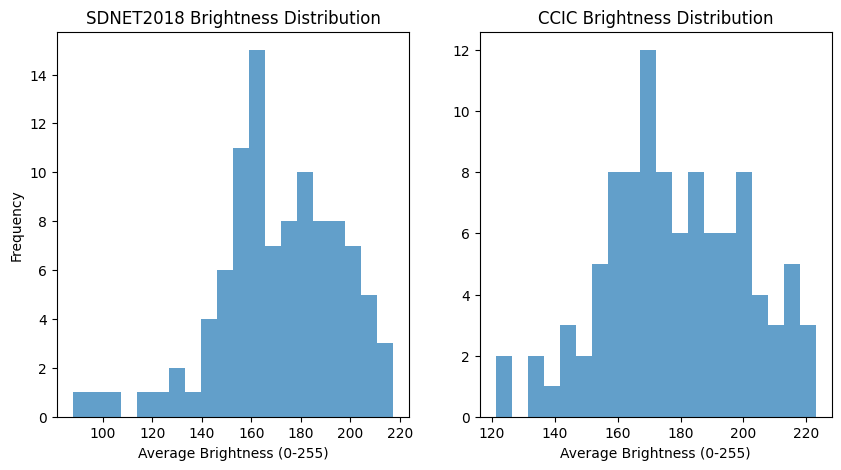

SDNET2018 avg brightness: 171.23
CCIC avg brightness: 178.33


In [4]:
# Function to compute average brightness
def get_brightness(img_path):
    img = Image.open(img_path).convert('L')  # Grayscale
    return np.mean(np.array(img))

# Sample a subset for speed (e.g., 100 images per dataset)
sample_sdnet = np.random.choice(sdnet_paths, min(100, len(sdnet_paths)), replace=False)
sample_ccic = np.random.choice(ccic_paths, min(100, len(ccic_paths)), replace=False)

sdnet_brightness = [get_brightness(p) for p in tqdm(sample_sdnet, desc='SDNET2018 Brightness')]
ccic_brightness = [get_brightness(p) for p in tqdm(sample_ccic, desc='CCIC Brightness')]

# Plot histograms
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(sdnet_brightness, bins=20, alpha=0.7)
plt.title('SDNET2018 Brightness Distribution')
plt.xlabel('Average Brightness (0-255)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(ccic_brightness, bins=20, alpha=0.7)
plt.title('CCIC Brightness Distribution')
plt.xlabel('Average Brightness (0-255)')
plt.show()

print(f"SDNET2018 avg brightness: {np.mean(sdnet_brightness):.2f}")
print(f"CCIC avg brightness: {np.mean(ccic_brightness):.2f}")

## Inspect Image Resolutions

Collect and plot image sizes to understand variability.

CCIC Sizes: 100%|██████████| 100/100 [00:00<00:00, 7820.38it/s]


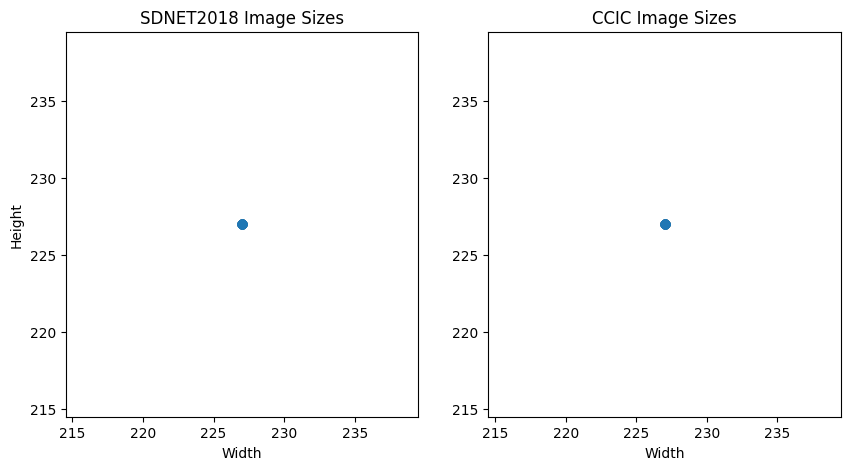

SDNET2018 size range: (227, 227) to (227, 227)
CCIC size range: (227, 227) to (227, 227)


In [5]:
# Function to get image size
def get_size(img_path):
    with Image.open(img_path) as img:
        return img.size  # (width, height)

# Sample sizes
sdnet_sizes = [get_size(p) for p in tqdm(sample_sdnet, desc='SDNET2018 Sizes')]
ccic_sizes = [get_size(p) for p in tqdm(sample_ccic, desc='CCIC Sizes')]

# Plot width vs height
sdnet_widths, sdnet_heights = zip(*sdnet_sizes)
ccic_widths, ccic_heights = zip(*ccic_sizes)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(sdnet_widths, sdnet_heights, alpha=0.5)
plt.title('SDNET2018 Image Sizes')
plt.xlabel('Width')
plt.ylabel('Height')

plt.subplot(1, 2, 2)
plt.scatter(ccic_widths, ccic_heights, alpha=0.5)
plt.title('CCIC Image Sizes')
plt.xlabel('Width')
plt.show()

print(f"SDNET2018 size range: {min(sdnet_sizes)} to {max(sdnet_sizes)}")
print(f"CCIC size range: {min(ccic_sizes)} to {max(ccic_sizes)}")

## Standardize Resolution

Demonstrate resizing a sample image to 224x224. In production, this will be handled in the data module with augmentations.

Original size: (227, 227)
Resized size: (224, 224)


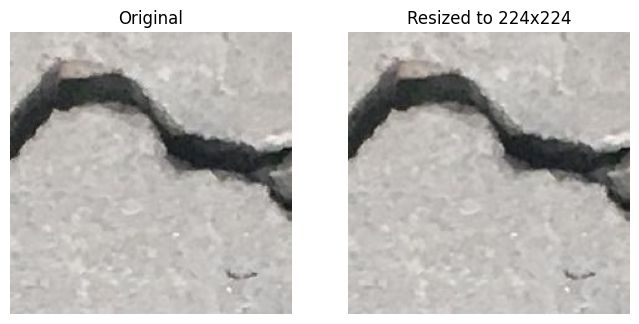

In [6]:
# Example resize
sample_img_path = all_paths[0]  # Pick first image
img = Image.open(sample_img_path)
print(f"Original size: {img.size}")

# Resize to 224x224
resized_img = img.resize((224, 224))
print(f"Resized size: {resized_img.size}")

# Display
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(resized_img)
plt.title('Resized to 224x224')
plt.axis('off')
plt.show()

# Note: For full preprocessing, integrate this into albumentations in the data module.